FFT
使用vivado 2018.3和HLS 2018.3设计，可在zynq 7010上运行

一、加载比特流文件到板卡，获取fft ip 的寄存器

In [1]:
from pynq import Overlay
overlay = Overlay("./fft.bit")
fft = overlay.getfft_0
fft.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  nfft = Register(nfft=0),
  pSrc = Register(pSrc=0),
  pDst = Register(pDst=0)
}

导入相关库

In [2]:
import numpy as np
import matplotlib.pyplot as plt

直流分量，幅度1024

16hz正弦波，幅度512

64hz正弦波，幅度256

将这些合成一个波

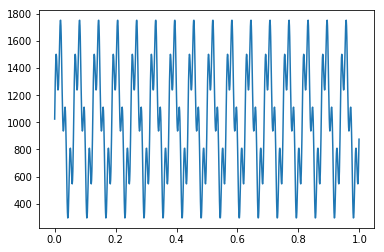

In [3]:
N = 1024
fs = 1024
f1 = 16
f2 = 64

t = np.arange(fs) / fs  # 1s
y = 1024 + 512*np.sin(2*np.pi*f1*t) + 256*np.sin(2*np.pi*f2*t)
plt.plot(t, y)

首先ARM做FFT，记录时间，用于之后与硬件做FFT对比

In [4]:
import time
start_time = time.time()
fft_y = np.fft.fft(y)  
abs_y = np.abs(fft_y)  # 取复数的绝对值，即复数的模
end_time = time.time()
print("耗时：{}s".format(end_time - start_time))

耗时：0.005483865737915039s


绘制频谱图

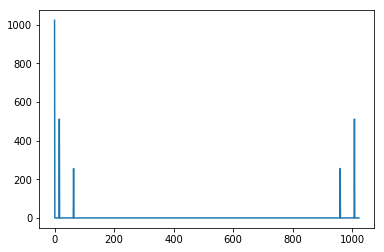

In [5]:
fft_x = np.arange(N)
abs_y = abs_y/N*2
abs_y[0] = abs_y[0]/2
plt.plot(fft_x,abs_y)

In [6]:
from pynq import Xlnk
sample_len = len(y)
xlnk = Xlnk()
input_buffer = xlnk.cma_array(shape=(sample_len,), dtype='i2')
output_buffer = xlnk.cma_array(shape=(sample_len,), dtype='i2')

In [7]:
np.copyto(input_buffer, np.uint16(y))
fft.register_map.nfft = 10
fft.register_map.pSrc = input_buffer.physical_address
fft.register_map.pDst = output_buffer.physical_address


In [8]:
fft.register_map.CTRL.AP_START = 0x01

start_time = time.time()
while True:
    reg = fft.register_map.CTRL
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.0007419586181640625s


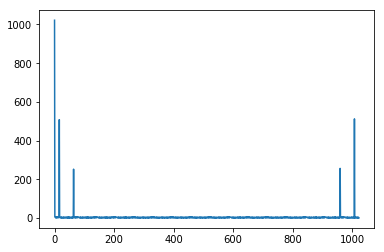

In [10]:
plt.plot(fft_x,output_buffer)

FPGA做FFT相比ARM快了7倍，提速明显，经过对比频谱图，表明结果正确